In [15]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import os
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'politik.settings')
import django
django.setup()

%matplotlib inline

# Lidt info at huske på

## 4 stemmetyper:
    * 1: For
    * 2: Imod
    * 3: Fraværende
    * 4: Hverken for eller imod
    
## 4 afstemningstyper
    * 1: Endelig
    * 2: Udvalgsindstilling
    * 3: Forslag til vedtagelse
    * 4: Ændringsforslag
    
## 5 Mødetyper
    * 1: Møde i salen
    * 2: Udvalgsmøde
    * 3: Andet møde
    * 4: ConciergeMeeting
    * 5: Statsrevisormøde
    
## 12 Aktørtyper
    * 5: Person

# Hvad kan vi så spørge om...
* Hvem stemmer mest nej? (person, parti)
* Hvem stemmer mest ja?  (person, parti)
* Hvis vi køre PCA (eller MCA eller CorEx) på personer, kommer de så til at cluster efter parti? Er der nogen der hører til et andet sted?
* Hvis vi gør det samme på parti niveau ser vi så vestre vs højre fløj?
* Hvem er den mest/mindst parti loyale person?
* ...


In [2]:
from poligraf.models import Aktør, Stemme
from django.db.models import Count, Avg
plt.style.use('default')

In [3]:
stemt = [list(a.stemme_set.all().values('typeid').annotate(Count('typeid'))) + [{'navn':a.navn}] for a in Aktør.objects.filter(typeid=5)]

In [4]:
stemme_type = {1:'for', 2:'imod', 3:'fraværende', 4:'neutral'}

In [5]:
stemt_better = []
for i, x in enumerate(stemt):
    if len(x)>1:
        linje = {'navn':x[-1]['navn']}
        for z in x:
            if 'typeid' in z.keys():
                if z['typeid'] in [1,2,3,4]:
                    linje[stemme_type[z['typeid']]] = z['typeid__count']
        stemt_better.append(linje)
    

In [6]:
stemt_data = pd.DataFrame(stemt_better).set_index('navn')
stemt_data.head()

,for,fraværende,imod,neutral
navn,,,,
Frank Aaen,337.0,218.0,198.0,12.0
Nicolai Wammen,160.0,787.0,130.0,3.0
Sara Olsvig,NaN,358.0,NaN,NaN
Christine Antorini,246.0,690.0,144.0,NaN
Alex Ahrendtsen,375.0,440.0,228.0,33.0


In [7]:
stemt_data['sum'] = stemt_data.sum(axis=1)
stemt_data['pfor'] = stemt_data['for']/stemt_data['sum']
stemt_data['pfraværende'] = stemt_data['fraværende']/stemt_data['sum']
stemt_data['pimod'] = stemt_data['imod']/stemt_data['sum']
stemt_data['pneutral'] = stemt_data['neutral']/stemt_data['sum']
stemt_data.head()

,for,fraværende,imod,neutral,sum,pfor,pfraværende,pimod,pneutral
navn,,,,,,,,,
Frank Aaen,337.0,218.0,198.0,12.0,765.0,0.440523,0.284967,0.258824,0.015686
Nicolai Wammen,160.0,787.0,130.0,3.0,1080.0,0.148148,0.728704,0.120370,0.002778
Sara Olsvig,NaN,358.0,NaN,NaN,358.0,NaN,1.000000,NaN,NaN
Christine Antorini,246.0,690.0,144.0,NaN,1080.0,0.227778,0.638889,0.133333,NaN
Alex Ahrendtsen,375.0,440.0,228.0,33.0,1076.0,0.348513,0.408922,0.211896,0.030669


In [8]:
stemt_data[stemt_data['sum'] > 100].sort_values('pfor', ascending=False).head()

,for,fraværende,imod,neutral,sum,pfor,pfraværende,pimod,pneutral
navn,,,,,,,,,
Annika Smith,79.0,NaN,27.0,NaN,106.0,0.745283,NaN,0.254717,NaN
Sanne Rubinke,75.0,1.0,24.0,1.0,101.0,0.742574,0.009901,0.237624,0.009901
Benedikte Kiær,69.0,7.0,26.0,8.0,110.0,0.627273,0.063636,0.236364,0.072727
Jesper Kiel,146.0,8.0,78.0,3.0,235.0,0.621277,0.034043,0.331915,0.012766
Karl H. Bornhøft,101.0,NaN,67.0,3.0,171.0,0.590643,NaN,0.391813,0.017544


In [9]:
stemt_data[stemt_data['sum'] > 100].sort_values('pimod', ascending=False).head()

,for,fraværende,imod,neutral,sum,pfor,pfraværende,pimod,pneutral
navn,,,,,,,,,
Anders Johansson,83.0,2.0,91.0,4.0,180.0,0.461111,0.011111,0.505556,0.022222
Sanne Bjørn,85.0,13.0,93.0,NaN,191.0,0.445026,0.068063,0.486911,NaN
Henrik Dahl,150.0,13.0,147.0,5.0,315.0,0.476190,0.041270,0.466667,0.015873
Peder Christensen,125.0,10.0,103.0,NaN,238.0,0.525210,0.042017,0.432773,NaN
Morten Løkkegaard,114.0,54.0,122.0,NaN,290.0,0.393103,0.186207,0.420690,NaN


In [10]:
stemt_data[stemt_data['sum'] > 100].sort_values('pneutral', ascending=False).head()

,for,fraværende,imod,neutral,sum,pfor,pfraværende,pimod,pneutral
navn,,,,,,,,,
Aaja Chemnitz Larsen,9.0,211.0,13.0,82.0,315.0,0.028571,0.669841,0.041270,0.260317
Malte Larsen,133.0,38.0,87.0,32.0,290.0,0.458621,0.131034,0.300000,0.110345
Erik Christensen,172.0,3.0,106.0,34.0,315.0,0.546032,0.009524,0.336508,0.107937
Kasper Roug,128.0,56.0,81.0,32.0,297.0,0.430976,0.188552,0.272727,0.107744
Daniel Toft Jakobsen,137.0,45.0,106.0,34.0,322.0,0.425466,0.139752,0.329193,0.105590


In [11]:
from scipy.stats import linregress

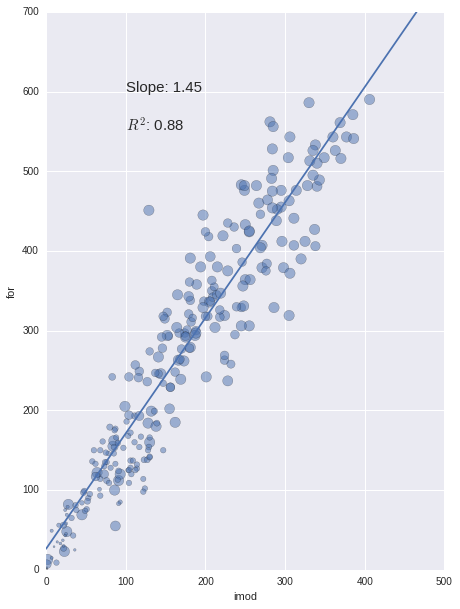

In [88]:
ax = stemt_data.plot(kind='scatter', x='imod', y='for', xlim=(0,500), ylim=(0,700), figsize=(7.14,10), s=stemt_data['sum']/10, alpha=0.5)
slope, intercept, r_value, p_value, std_err = linregress(stemt_data.dropna()['imod'], stemt_data.dropna()['for'])
ax.plot(range(700), [slope*x+intercept for x in range(700)])
ax.text(100, 600, r'Slope: {:.2f}'.format(slope), fontsize=15)
ax.text(100, 550, r'$R^2$: {:.2f}'.format(r_value**2), fontsize=15)

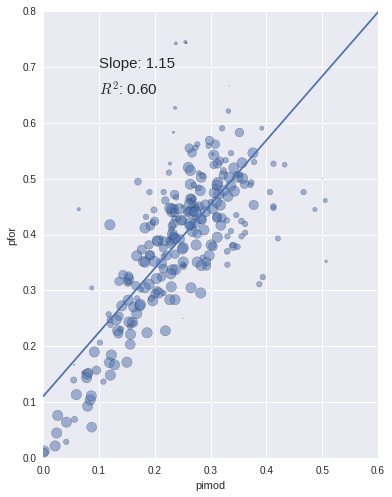

In [92]:
ax = stemt_data.plot(kind='scatter', x='pimod', y='pfor', figsize=(6,8), xlim=(0,0.6), ylim=(0,0.8), s=stemt_data['sum']/10, alpha=0.5)
slope, intercept, r_value, p_value, std_err = linregress(stemt_data.dropna()['pimod'], stemt_data.dropna()['pfor'])
ax.plot(np.arange(0,1,0.1), [slope*x+intercept for x in np.arange(0,1,0.1)])
ax.text(0.1, 0.7, r'Slope: {:.2f}'.format(slope), fontsize=15)
ax.text(0.1, 0.65, r'$R^2$: {:.2f}'.format(r_value**2), fontsize=15)

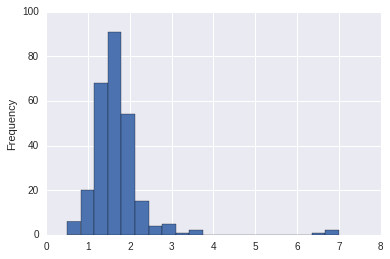

In [94]:
(stemt_data['for']/stemt_data['imod']).plot(kind='hist', bins=20)

In [96]:
stemt_data.head()

,for,fraværende,imod,neutral,sum,pfor,pfraværende,pimod,pneutral
navn,,,,,,,,,
Frank Aaen,337.0,218.0,198.0,12.0,765.0,0.440523,0.284967,0.258824,0.015686
Nicolai Wammen,160.0,787.0,130.0,3.0,1080.0,0.148148,0.728704,0.120370,0.002778
Sara Olsvig,NaN,358.0,NaN,NaN,358.0,NaN,1.000000,NaN,NaN
Christine Antorini,246.0,690.0,144.0,NaN,1080.0,0.227778,0.638889,0.133333,NaN
Alex Ahrendtsen,375.0,440.0,228.0,33.0,1076.0,0.348513,0.408922,0.211896,0.030669


In [100]:
stemt_data.loc['Frank Aaen']['pfor']/stemt_data.loc['Frank Aaen']['pimod']

1.7020202020202018